# Imports

In [1]:
import pickle
import os
import casadi as cd

from environments import environment as Environment
from Reinforced_MPC.agents.AC_MPC_agent_NN import AC_MPC_agent_NN_TR as Agent
from Reinforced_MPC.tools.RL_AC_MPC import RL_AC_MPC as MPC

from do_mpc.model import Model
from matplotlib import pyplot as plt
from sys import stdout

from scipy.linalg import solve_discrete_are

import tensorflow as tf
tf.random.set_seed(0)

from tensorflow import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def progress_episodes(replay: int, max_replays: int, episode: int, episodes_per_replay: int, suffix = ''):
    bar_len = 60
    filled_len = int(round(bar_len * episode / int(episodes_per_replay)))

    percents = round(100.0 * episode / int(episodes_per_replay), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    stdout.write(f'Replay {replay}/{max_replays},\t[' + bar  + f'] {episode}/{episodes_per_replay} {percents}%\r')

# Training parameters

In [3]:
save_path = f"data\\agent\\TRGD_MPC\\"
fig_path = f"figs\\agent\\TRGD_MPC\\"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

n_episodes = 2000
steps_per_episode = 50
n_batch = 50

memory_size = 250
shortterm_memory_size = n_batch
n_samples = n_batch * steps_per_episode

behave_rng_seed = 42
exploration_rng_seed = 24
tf_rng_seed = 99

exploration_std = 1e-1
epsilon_decay = (0.01/1)**(1/(n_episodes//memory_size))
gamma = 1


TR_settings = {"delta_min": 1e-10, "delta": 1e-3, "delta_max": 1e-1}

training_hp = {
    "n_episodes": n_episodes,
    "steps_per_episode": steps_per_episode,
    "n_samples": n_samples,
    "memory_size": memory_size,
    "shortterm_memory_size": shortterm_memory_size,
    "behave_rng_seed": behave_rng_seed,
    "exploration_rng_seed": exploration_rng_seed,
    "tf_rng_seed": tf_rng_seed,
    "exploration_std": exploration_std,
    "epsilon_decay": epsilon_decay,
    "gamma": gamma,
}

# Build the model for the MPC_agent

In [4]:
model = Model("discrete")

x = model.set_variable(var_type = "_x", var_name = "x", shape = (2,1))
u = model.set_variable(var_type = "_u", var_name = "u", shape = (1,1))

A11 = model.set_variable(var_type = "_p", var_name = "A11", shape = (1, 1))
A12 = model.set_variable(var_type = "_p", var_name = "A12", shape = (1, 1))
A22 = model.set_variable(var_type = "_p", var_name = "A22", shape = (1, 1))
A = cd.vertcat(cd.horzcat(A11, A12), cd.horzcat(0, A22))
B = model.set_variable(var_type = "_p", var_name = "B", shape = (2,1))
bias = model.set_variable(var_type = "_p", var_name = "bias", shape = (2,1))
lower_backoff = model.set_variable(var_type = "_p", var_name = "lower_backoff", shape = (1,1))


x_next = A @ x + B @ u + bias
model.set_rhs("x", x_next)

model.setup()


# Build the MPC based on the previous model

In [5]:
actor = MPC(model=model)

Q_approx =  cd.diag(cd.DM([[1, 1]]))
R_approx = cd.diag(cd.DM([[0.5]]))
lterm = x.T @ Q_approx @ x + u.T @ R_approx @ u
A_approx = cd.DM([[1,  0.25], [0, 1]])
B_approx = cd.DM([[0.1], [0.3]])

S = solve_discrete_are(A_approx, B_approx, Q_approx, R_approx)
mterm = x.T @ S @ x
actor.set_objective(lterm = lterm, mterm = mterm)

actor.set_rterm(u = 0)

actor.bounds["lower", "_u", "u"] = -1
actor.bounds["upper", "_u", "u"] = +1

x_lb = cd.DM([0, -1])
x_ub = cd.DM([1, +1])
x_lower_limit = x_lb + cd.vertcat(lower_backoff, cd.DM(0))
x_upper_limit = x_ub
actor.set_nl_cons(expr_name = "x_lower_limit", expr = +(x_lower_limit - x), ub = 0, soft_constraint = True, penalty_term_cons = 1e2) 
actor.set_nl_cons(expr_name = "x_upper_limit", expr = -(x_upper_limit - x), ub = 0, soft_constraint = True, penalty_term_cons = 1e2)

actor.set_param(n_horizon = 10, t_step= 1, nlpsol_opts = {"ipopt": {"print_level": 0, "tol": 1e-8}, "print_time": False }, gamma = gamma)

p_template = actor.get_p_template(1)
p_template["_p", 0, "A11"] = A_approx[0,0]
p_template["_p", 0, "A12"] = A_approx[0,1]
p_template["_p", 0, "A22"] = A_approx[1,1]
p_template["_p", 0, "B"] = B_approx
actor.set_p_fun(lambda t_now: p_template)

actor.setup()

# Build the Q-NN

In [6]:
n_layers  = 2
n_units = 20
Q_lr = 1e-3

training_hp["n_layers"] = n_layers
training_hp["n_units"] = n_units
training_hp["Q_lr"] = Q_lr

critic_optimizer = keras.optimizers.Adam(learning_rate = Q_lr)
critic_loss = keras.losses.Huber()

training_hp["critic_optimizer"] = critic_optimizer.name
training_hp["critic_loss"] = critic_loss.name


input_layer = keras.layers.Input(shape = x.shape[0] + u.shape[0] + u.shape[0])
hidden = keras.layers.Dense(n_units, activation = "tanh")(input_layer)

for idx in range(n_layers - 1):
    hidden = keras.layers.Dense(n_units, activation = "tanh")(hidden)

output_layer = keras.layers.Dense(1, activation = "sigmoid")(hidden)

Q_NN = keras.Model(inputs = input_layer, outputs = output_layer, name = "Q_NN")

Q_NN.summary()

Q_NN.compile(
    optimizer = critic_optimizer,
    loss = critic_loss,
    metrics = ["mse", "mae"]
    )

Model: "Q_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 541 (2.11 KB)
Trainable params: 541 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
critic_training_kwargs = {
    "batch_size": 256,
    "epochs": 5000,
    "callbacks": [keras.callbacks.EarlyStopping(monitor = "loss", patience = 50, restore_best_weights = True)],
    "verbose": 0,
    }

# Build the AC_MPC_Agent based on the MPC

In [8]:
RL_settings = {
    "memory_size": memory_size,
    "behave_rng_seed": behave_rng_seed,
    "exploration_rng_seed": exploration_rng_seed,
    "exploration_std": exploration_std,
    "gamma": gamma
}
critic_settings = {
    "log_basis": 10.,
    "log_offset": 1e-4,
}
n_critic_horizon = 10
agent = Agent(
    actor_mpc = actor,
    critic = Q_NN,
    n_critic_horizon = n_critic_horizon,
    TR_kwargs = TR_settings,
    critic_settings = critic_settings,
    **RL_settings)
agent.save(save_path + "untrained\\")

C:\Users\DMBra\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Build the environment

In [9]:
env = Environment()

# Untrained performance

In [10]:
x0 = cd.DM([0.5, 0.5]).full()
u_prev = cd.DM([0])

env.set_initial_state(x0)

stage_cost_list = []
X_untrained = [x0]
U_untrained = []
for idx in range(steps_per_episode):
    u = agent.act(x0)
    x_next, stage_cost, done_flag = env.make_step(u)

    x0 = x_next.copy()
    u_prev = u.copy()

    stage_cost_list.append(stage_cost)
    X_untrained.append(x0)
    U_untrained.append(u)

stage_cost_list = cd.DM(stage_cost_list)
X_untrained = cd.horzcat(*X_untrained).T
U_untrained = cd.horzcat(*U_untrained).T

agent.actor.reset_history()
agent.actor_behavior.reset_history()
agent.replay_mpc.reset_history()

print(f"Closed Loop cost: {stage_cost_list.full().sum()}")

c:\Users\DMBra\.conda\envs\ECC24_TR_Improved_QN_PO_for_MPC_in_RL\Lib\site-packages\do_mpc\controller\_mpc.py:897: UserWarning: Intial guess for the MPC was not set. The solver call is likely to fail.
  warnings.warn('Intial guess for the MPC was not set. The solver call is likely to fail.')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Closed Loop cost: 8.304749227470255


In [11]:
if not os.path.exists(save_path + "\\performance"):
    os.makedirs(save_path + "\\performance")

with open(save_path + "\\performance\\untrained_performance_X.pkl", "wb") as f:
    pickle.dump(X_untrained, f)
    
with open(save_path + "\\performance\\untrained_performance_U.pkl", "wb") as f:
    pickle.dump(U_untrained, f)

with open(save_path + "\\performance\\untrained_performance_J.pkl", "wb") as f:
    pickle.dump(stage_cost_list, f)


# Plot the untrained performance

Below you see the closed loop cost of the untrained MPC agent, given an initial condition of $x_0 = [0.5, 0.5]^\top$.

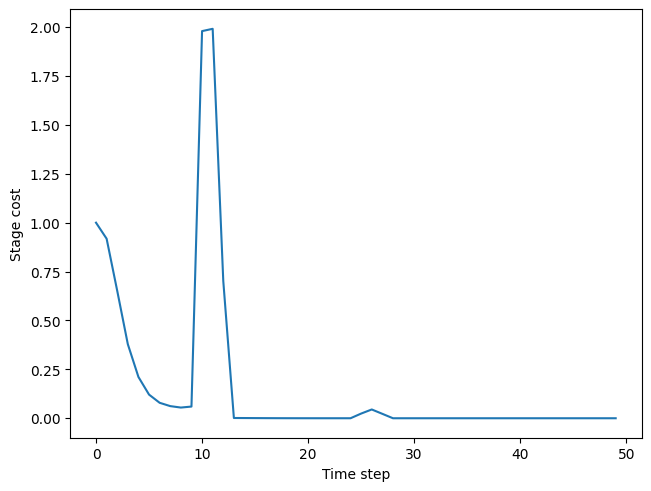

In [12]:
fig, ax_stage_cost = plt.subplots(nrows = 1, ncols = 1, constrained_layout = True)

_ = ax_stage_cost.plot(stage_cost_list)

_ = ax_stage_cost.set_xlabel("Time step")
_ = ax_stage_cost.set_ylabel("Stage cost")

Below you see the trajectory of the untrained system, given an initial condition of $x_0 = [0.5, 0.5]^\top$.

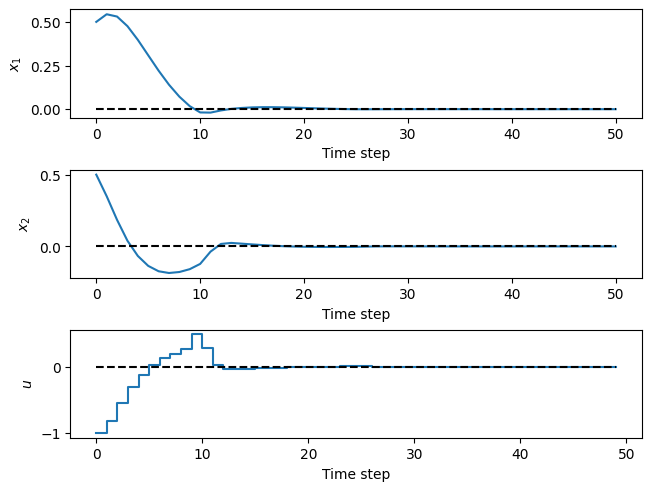

In [13]:
fig, ax_trajectory_untrained = plt.subplots(nrows = 3, ncols = 1, constrained_layout = True)

for axis in ax_trajectory_untrained:
    axis.set_xlabel("Time step")

ax_trajectory_untrained[0].set_ylabel(r"$x_1$")
ax_trajectory_untrained[1].set_ylabel(r"$x_2$")
ax_trajectory_untrained[2].set_ylabel(r"$u$")

ax_trajectory_untrained[0].plot(X_untrained[:,0])
ax_trajectory_untrained[0].plot([0]*X_untrained.shape[0], "--", color = "black")

ax_trajectory_untrained[1].plot(X_untrained[:,1])
ax_trajectory_untrained[1].plot([0]*X_untrained.shape[0], "--", color = "black")

ax_trajectory_untrained[2].step(x = range(U_untrained[:,0].shape[0]), y = U_untrained[:,0])
ax_trajectory_untrained[2].plot([0]*U_untrained.shape[0], "--", color = "black")

# Training loop

In [14]:
parameters = [agent.actor.p_fun(0).master.T]
cl_cost = []
regularization_list = []

u0_initial = agent.actor.u0.master.full().copy()

env.reset()

averaged_closed_loop_cost_list = []
averaged_closed_loop_cost_loc_list = []
best_closed_loop_cost = None
counter = 0
replay_count = 1


for episode in range(n_episodes):
    progress_episodes(replay_count, n_episodes//n_batch, counter + 1, n_batch)


    if episode % n_batch == 0:
        env.reset(random = False)
    else:
        env.reset(random = True)
        
    x0 = env.x_num.copy()
    u_prev = u0_initial.copy()
    agent.actor.u0.master = u_prev.copy()

    agent.actor.reset_history()
    agent.actor_behavior.reset_history()
    agent.replay_mpc.reset_history()

    closed_loop_cost = 0
    
    for step in range(steps_per_episode):
        u0 = agent.behave(x0)
        x_next, reward, done_flag = env.make_step(action = u0)
        agent.remember(old_state = x0, old_action = u_prev, action = u0, reward = reward, next_state = x_next, done_flag = done_flag)
        x0 = x_next.copy()
        u_prev = u0.copy()

        closed_loop_cost += reward

    averaged_closed_loop_cost_loc_list.append(closed_loop_cost)
    counter += 1
    cl_cost.append(closed_loop_cost)
    
    agent.remember_episode()
    
    if counter < n_batch:
        continue
    
    averaged_closed_loop_cost_loc = agent._get_closed_loop_cost()
    if (best_closed_loop_cost is None) or (best_closed_loop_cost > averaged_closed_loop_cost_loc):
        best_closed_loop_cost = averaged_closed_loop_cost_loc

        agent.save(save_path)

    averaged_closed_loop_cost_list.append(averaged_closed_loop_cost_loc)
    averaged_closed_loop_cost_loc_list = []
    counter = 0
    
    print()
    
    
    print(f"Averaged closed loop cost of this run: {averaged_closed_loop_cost_list[-1]:.3f} \t Best average closed loop cost so far: {best_closed_loop_cost:.3f}")
    
    
    continue_bool = agent.replay(critic_training_kwargs = critic_training_kwargs)
    if not continue_bool:
        break

    replay_count += 1
    
    agent.decay_epsilon()
    parameters.append(agent.actor.p_fun(0).master.T)

    print("Agent parameters: {}".format(agent.actor.p_fun(0)["_p", 0]))
    print()
parameters = cd.vertcat(*parameters)
        

Replay 1/40,	[============================================================] 50/50 100.0%
Averaged closed loop cost of this run: 28.271 	 Best average closed loop cost so far: 28.271
Next optimal actions:	[============================================================] 2500/2500 100.0%


In [ ]:
agent = Agent.load(save_path)
untrained_agent = Agent.load(save_path + "untrained\\")
print("Agent parameters: {}".format(agent.actor.p_fun(0)["_p", 0]))
print("Agent parameters (untrained): {}".format(untrained_agent.actor.p_fun(0)["_p", 0]))

# Save the model parameters and the MPC

In [ ]:
agent.save(save_path  + "agent")

with open(save_path + "training_hp.pkl", "wb") as f:
    pickle.dump(training_hp, f)

with open(save_path + "parameters.pkl", "wb") as f:
    pickle.dump(parameters, f)

with open(save_path + "cl_cost.pkl", "wb") as f:
    pickle.dump(cl_cost, f)

with open(save_path + "regularization_list.pkl", "wb") as f:
    pickle.dump(regularization_list, f)

# Build the MPC benchmark
The benchmark is an MPC with the exact model and full prediction horizon.

First the exact model is setup.

In [ ]:
exact_model = Model("discrete")

x_exact = exact_model.set_variable(var_type = "_x", var_name = "x", shape = (2,1))
u_exact = exact_model.set_variable(var_type = "_u", var_name = "u", shape = (1,1))

A_exact = cd.DM([[0.9,  0.35], [0, 1.1]])
B_exact = cd.DM([[0.0813], [0.2]])

x_next_exact = A_exact @ x_exact + B_exact @ u_exact
exact_model.set_rhs("x", x_next_exact)

exact_model.setup()

Now the benchmark MPC is set up.

In [ ]:
benchmark_MPC = MPC(model = exact_model)

q_exact = cd.DM([1, 1])
lterm = x_exact.T @ cd.diag(q_exact) @ x_exact + 0.5 * u_exact.T @ u_exact

S_exact = solve_discrete_are(A_exact, B_exact, cd.diag(q_exact), cd.DM(0.5))
mterm = x_exact.T @ S_exact @ x_exact
benchmark_MPC.set_objective(lterm = lterm, mterm = mterm)

benchmark_MPC.set_rterm(u = 0)

benchmark_MPC.bounds["lower", "_u", "u"] = -1
benchmark_MPC.bounds["upper", "_u", "u"] = +1

x_lb_exact = cd.DM([0, -1])
x_ub_exact = cd.DM([1, +1])

benchmark_MPC.set_nl_cons(expr_name = "x_lower_limit", expr = x_lb_exact +(- x_exact), ub = 0, soft_constraint = True, penalty_term_cons = 1e2)
benchmark_MPC.set_nl_cons(expr_name = "x_upper_limit", expr = x_exact - x_ub_exact, ub = 0, soft_constraint = True, penalty_term_cons = 1e2)

benchmark_MPC.set_param(n_horizon = 50, t_step= 1, nlpsol_opts = {"ipopt": {"print_level": 0, "tol": 1e-6}, "print_time": False }, gamma = gamma)


benchmark_MPC.setup()

Run the benchmark MPC on the actual system

In [ ]:
x0 = cd.DM([0.5, 0.5]).full()
u_prev = cd.DM([0])

env.set_initial_state(x0)

stage_cost_benchmark_list = []
X_benchmark = [x0]
U_benchmark = []
for idx in range(steps_per_episode):
    u = benchmark_MPC.make_step(x0)
    x_next, stage_cost, done_flag = env.make_step(u)

    x0 = x_next.copy()
    u_prev = u.copy()

    stage_cost_benchmark_list.append(stage_cost)
    X_benchmark.append(x0)
    U_benchmark.append(u)

stage_cost_benchmark_list = cd.DM(stage_cost_benchmark_list)
X_benchmark = cd.horzcat(*X_benchmark).T
U_benchmark = cd.horzcat(*U_benchmark).T

print(f"Closed Loop cost: {stage_cost_benchmark_list.full().sum()}")

In [ ]:
test_env = Environment(seed = 10)

In [ ]:
closed_loop_cost_benchmark_list = []
for episode in range(n_batch):
    if episode == 0:
        env.reset(random = False)
    else:
        env.reset(random = True)

    x0 = env.x_num.copy()
    u_prev = cd.DM([0])

    closed_loop_cost_benchmark = 0
    for idx in range(steps_per_episode):
        u = benchmark_MPC.make_step(x0)
        x_next, stage_cost, done_flag = env.make_step(u)

        x0 = x_next.copy()
        u_prev = u.copy()

        closed_loop_cost_benchmark += stage_cost

    closed_loop_cost_benchmark_list.append(closed_loop_cost_benchmark)

average_closed_loop_cost_benchmark = sum(closed_loop_cost_benchmark_list)/len(closed_loop_cost_benchmark_list)
print(f"Averaged closed Loop cost {n_batch} runs: {average_closed_loop_cost_benchmark:.3f}")

In [ ]:
if not os.path.exists(save_path + "\\performance"):
    os.makedirs(save_path + "\\performance")

with open(save_path + "\\performance\\benchmark_performance_X.pkl", "wb") as f:
    pickle.dump(X_benchmark, f)
    
with open(save_path + "\\performance\\benchmark_performance_U.pkl", "wb") as f:
    pickle.dump(U_benchmark, f)

with open(save_path + "\\performance\\benchmark_performance_J.pkl", "wb") as f:
    pickle.dump(stage_cost_benchmark_list, f)


# Trained performance

In [ ]:
average_closed_loop_cost_trained = 0
for episode in range(n_batch):
    if episode == 0:
        env.reset(random = False)
    else:
        env.reset(random = True)

    x0 = env.x_num.copy()
    u_prev = cd.DM([0])

    stage_cost_trained_list = []
    X_trained = [x0]
    U_trained = []
    for idx in range(steps_per_episode):
        u = agent.act(x0)
        x_next, stage_cost, done_flag = env.make_step(u)

        x0 = x_next.copy()
        u_prev = u.copy()

        stage_cost_trained_list.append(stage_cost)
        X_trained.append(x0)
        U_trained.append(u)

    stage_cost_trained_list = cd.DM(stage_cost_trained_list)
    X_trained = cd.horzcat(*X_trained).T
    U_trained = cd.horzcat(*U_trained).T

    average_closed_loop_cost_trained = episode/(episode+1) * average_closed_loop_cost_trained + 1/(episode+1) * stage_cost_trained_list.full().sum()

print(f"Averaged closed Loop cost {n_batch} runs: {average_closed_loop_cost_trained:.3f}")

In [ ]:
env.reset()

agent.actor.reset_history()
agent.actor_behavior.reset_history()
agent.replay_mpc.reset_history()

x0 = cd.DM([0.5, 0.5]).full()
u_prev = cd.DM([0])

env.set_initial_state(x0)

stage_cost_trained_list = []
X_trained = [x0]
U_trained = []
for idx in range(steps_per_episode):
    u = agent.act(x0)
    x_next, stage_cost, done_flag = env.make_step(u)

    x0 = x_next.copy()
    u_prev = u.copy()

    stage_cost_trained_list.append(stage_cost)
    X_trained.append(x0)
    U_trained.append(u)

stage_cost_trained_list = cd.DM(stage_cost_trained_list)
X_trained = cd.horzcat(*X_trained).T
U_trained = cd.horzcat(*U_trained).T

agent.actor.reset_history()
agent.actor_behavior.reset_history()
agent.replay_mpc.reset_history()

print(f"Closed Loop cost: {stage_cost_trained_list.full().sum()}")

In [ ]:
if not os.path.exists(save_path + "\\performance"):
    os.makedirs(save_path + "\\performance")

with open(save_path + "\\performance\\trained_performance_X.pkl", "wb") as f:
    pickle.dump(X_trained, f)
    
with open(save_path + "\\performance\\trained_performance_U.pkl", "wb") as f:
    pickle.dump(U_trained, f)

with open(save_path + "\\performance\\trained_performance_J.pkl", "wb") as f:
    pickle.dump(stage_cost_trained_list, f)

with open(save_path + "\\performance\\averaged_cl_cost_over_episodes.pkl", "wb") as f:
    pickle.dump(averaged_closed_loop_cost_list, f)


# Plot the trained performance

Below you see the closed loop cost of the trained MPC agent, given an initial condition of $x_0 = [0.5, 0.5]^\top$.

In [ ]:
fig, ax_stage_cost_trained = plt.subplots(nrows = 1, ncols = 1, constrained_layout = True)

_ = ax_stage_cost_trained.plot(stage_cost_benchmark_list, label = "benchmark")
_ = ax_stage_cost_trained.plot(stage_cost_trained_list, label = "AC_MPC")

_ = ax_stage_cost_trained.set_xlabel("Time step")
_ = ax_stage_cost_trained.set_ylabel("Stage cost")

_ = ax_stage_cost_trained.legend(loc = "upper right")

plt.savefig(fig_path + "stage_cost_comparison.png")

Below you see the trajectory of the trained system, given an initial condition of $x_0 = [0.5, 0.5]^\top$.

In [ ]:
fig, ax_trajectory_trained = plt.subplots(nrows = 3, ncols = 1, constrained_layout = True)

for axis in ax_trajectory_trained:
    axis.set_xlabel("Time step")

_ = ax_trajectory_trained[0].set_ylabel(r"$x_1$")
_ = ax_trajectory_trained[1].set_ylabel(r"$x_2$")
_ = ax_trajectory_trained[2].set_ylabel(r"$u$")

_ = ax_trajectory_trained[0].plot(X_benchmark[:,0], label = "benchmark")
_ = ax_trajectory_trained[0].plot(X_untrained[:,0], label = "untrained")
_ = ax_trajectory_trained[0].plot(X_trained[:,0], label = "trained")
_ = ax_trajectory_trained[0].plot([0]*X_trained.shape[0], "--", color = "black")
_ = ax_trajectory_trained[0].legend(loc = "upper right")

_ = ax_trajectory_trained[1].plot(X_benchmark[:,1], label = "benchmark")
_ = ax_trajectory_trained[1].plot(X_untrained[:,1], label = "untrained")
_ = ax_trajectory_trained[1].plot(X_trained[:,1], label = "trained")
_ = ax_trajectory_trained[1].plot([0]*X_trained.shape[0], "--", color = "black")

_ = ax_trajectory_trained[2].step(x = range(U_benchmark[:,0].shape[0]), y = U_benchmark[:,0], label = "benchmark", where = "post")
_ = ax_trajectory_trained[2].step(x = range(U_untrained[:,0].shape[0]), y = U_untrained[:,0], label = "untrained",  where = "post")
_ = ax_trajectory_trained[2].step(x = range(U_trained[:,0].shape[0]), y = U_trained[:,0], label = "trained",  where = "post")
_ = ax_trajectory_trained[2].plot([0]*U_trained.shape[0], "--", color = "black")

plt.savefig(fig_path + "benchmark_vs_trained.png")

Below you see the training trajectory of the parameters of the trained system.

In [ ]:
nrows = 2
ncols = 4

k = 0.75

fig, ax_parameters = plt.subplots(nrows = nrows, ncols = ncols, figsize = (k * 5 * ncols, k * 4 * nrows), constrained_layout = True)

for axis in ax_parameters.flatten():
    axis.set_xlabel("Update step")

_ = ax_parameters[0, 0].set_ylabel(r"$A_{11}$")
_ = ax_parameters[0, 1].set_ylabel(r"$A_{12}$")
_ = ax_parameters[1, 1].set_ylabel(r"$A_{22}$")
_ = ax_parameters[0, 2].set_ylabel(r"$B_{11}$")
_ = ax_parameters[1, 2].set_ylabel(r"$B_{12}$")
_ = ax_parameters[0, 3].set_ylabel(r"$b$")
_ = ax_parameters[1, 3].set_ylabel(r"$\Delta x$")

_ = ax_parameters[0, 0].plot(parameters[:, 0])
_ = ax_parameters[0, 1].plot(parameters[:, 1])
# _ = ax_parameters[1, 0].plot(parameters[:, 1 - 1])
_ = ax_parameters[1, 1].plot(parameters[:, 2])
_ = ax_parameters[0, 2].plot(parameters[:, 4 - 1])
_ = ax_parameters[1, 2].plot(parameters[:, 5 - 1])
_ = ax_parameters[0, 3].plot(parameters[:, 6 - 1])
_ = ax_parameters[0, 3].plot(parameters[:, 7 - 1])
_ = ax_parameters[1, 3].plot(parameters[:, 8 - 1])

plt.savefig(fig_path + "parameters.png")

Closed loop cost over the episodes

In [ ]:
fig, ax_averaged_cl_cost_over_episodes = plt.subplots(nrows = 1, ncols = 1, constrained_layout = True)

_ = ax_averaged_cl_cost_over_episodes.plot([average_closed_loop_cost_benchmark]*len(averaged_closed_loop_cost_list), label = "benchmark")
_ = ax_averaged_cl_cost_over_episodes.plot(averaged_closed_loop_cost_list, label = "AC_MPC_TR")

_ = ax_averaged_cl_cost_over_episodes.set_xlabel("Episode")
_ = ax_averaged_cl_cost_over_episodes.set_ylabel("Averaged closed loop cost")

_ = ax_averaged_cl_cost_over_episodes.legend(loc = "upper right")

_ = ax_averaged_cl_cost_over_episodes.set_ylim([10, 30])


plt.savefig(fig_path + "averaged_cl_cost_over_episodes.png")